In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, make_scorer, ConfusionMatrixDisplay, precision_recall_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced

from xgboost import XGBClassifier


In [2]:
random_seed = 1910
features_data = pd.read_csv('../data/features/stage_1_features.csv')
features_1 = [
    'distance2mean', 'trend_measure', 'distance_rdw',
    'question_pool', 'longitudinal_prop', 'distance2edition'
]
features_2 = [
    'distance2mean', 'trend_measure', 'leave_one_out_score', 'distance_rdw',
    'question_pool', 'longitudinal_prop', 'distance2edition'
]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    features_data[features_1],
    features_data['dropped'], 
    train_size   = 0.8,
    stratify     = features_data['dropped'],
    random_state = random_seed
)

In [82]:
sm = SMOTE(
    sampling_strategy = 0.25,
    random_state = random_seed
)

tmk = TomekLinks(
    sampling_strategy = 'majority',
    n_jobs = -1
)

enn = EditedNearestNeighbours(
    sampling_strategy = 'majority',
    n_jobs = -1
)

resampler = SMOTETomek(
    smote = sm,
    tomek = tmk,
    random_state = random_seed,
    n_jobs = -1
)

resampler_enn = SMOTEENN(
    smote = sm,
    enn = enn,
    random_state = random_seed,
    n_jobs = -1
)

In [5]:
stratified_kfold = StratifiedKFold(
    n_splits = 5, 
    shuffle  = True, 
    random_state = random_seed
)

In [6]:
f1_minority = make_scorer(f1_score, pos_label=1)

In [7]:
X_res, y_res = resampler.fit_resample(X_train, y_train)
y_res.value_counts()

dropped
0    32685
1    13414
Name: count, dtype: int64

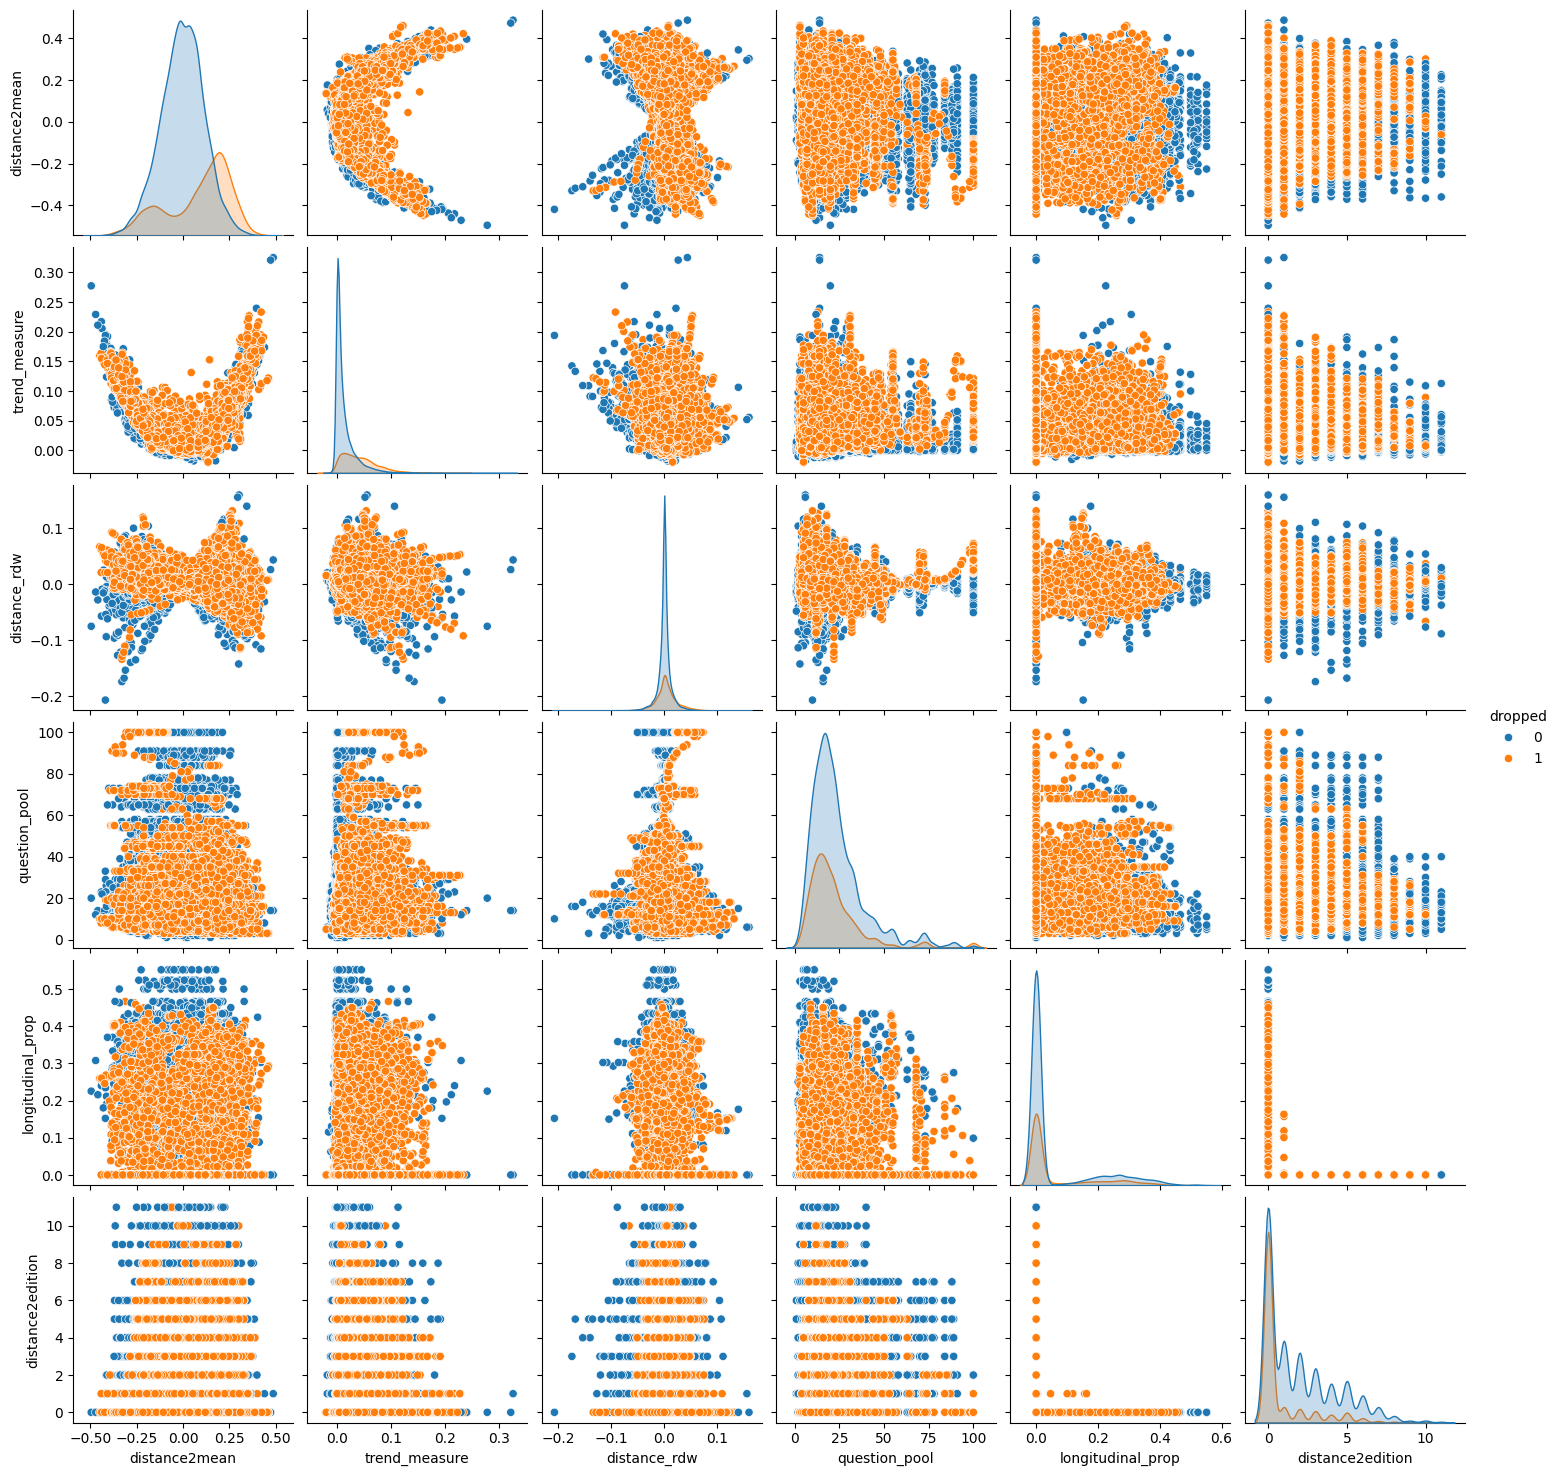

In [8]:
import seaborn as sns

z = pd.DataFrame(X_res)
z['dropped'] = y_res
sns.pairplot(z, hue='dropped')

## Logistic Regression

In [11]:
pipeline_logreg = Pipeline([
    ('resampler', resampler),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter = 1000,
        random_state = random_seed,
        class_weight = None
    ))
])

param_grid_logreg = [
    # For solvers that only support l2
    {'logreg__solver': ['newton-cg', 'lbfgs', 'sag'],
     'logreg__penalty': ['l2'],
     'logreg__C': np.logspace(-4, 4, 9)},
    
    # For no penalty
    {'logreg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'logreg__penalty': [None]},
    
    # For liblinear
    {'logreg__solver': ['liblinear'],
     'logreg__penalty': ['l1', 'l2'],
     'logreg__C': np.logspace(-4, 4, 9)},
    
    # For saga with l1 and l2
    {'logreg__solver': ['saga'],
     'logreg__penalty': ['l1', 'l2'],
     'logreg__C': np.logspace(-4, 4, 9)},
    
    # For saga with elasticnet
    {'logreg__solver': ['saga'],
     'logreg__penalty': ['elasticnet'],
     'logreg__C': np.logspace(-4, 4, 9),
     'logreg__l1_ratio': [0.2, 0.5, 0.8]}
]

grid_search_logreg = GridSearchCV(
    pipeline_logreg,
    param_grid_logreg,
    cv      = stratified_kfold,
    scoring = f1_minority,
    n_jobs  = -1,
    verbose = True
)

In [12]:
grid_search_logreg.fit(X_train, y_train)

print("Best parameters:", grid_search_logreg.best_params_)
print("Best cross-validation score:", grid_search_logreg.best_score_)

Fitting 5 folds for each of 94 candidates, totalling 470 fits
Best parameters: {'logreg__C': np.float64(0.001), 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
Best cross-validation score: 0.33029770431861794


In [13]:
best_logreg = grid_search_logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_logreg))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.94      0.41      0.96      0.62      0.41      8384
          1       0.25      0.41      0.94      0.31      0.62      0.37       388

avg / total       0.94      0.92      0.44      0.93      0.62      0.41      8772



## SVC Classifier

In [ ]:
pipeline_svc = Pipeline([
    ('resampler', resampler),
    ('scaler', StandardScaler()),
    ('svc', SVC(
        max_iter = 1000,
        random_state = random_seed,
        class_weight = None
    ))
])

param_grid_svc = [
    # RBF kernel
    {'svc__kernel': ['rbf'],
     'svc__C': np.logspace(-3, 3, 7),
     'svc__gamma': np.logspace(-4, 0, 5)},
    
    # Linear kernel
    {'svc__kernel': ['linear'],
     'svc__C': np.logspace(-3, 3, 7)},
    
    # Polynomial kernel
    {'svc__kernel': ['poly'],
     'svc__C': np.logspace(-3, 3, 7),
     'svc__degree': [2, 3, 4],
     'svc__gamma': np.logspace(-4, 0, 5)},
     
    # Sigmoid kernel
    {'svc__kernel': ['sigmoid'],
     'svc__C': np.logspace(-3, 3, 7),
     'svc__gamma': np.logspace(-4, 0, 5)}
]

grid_search_svc = GridSearchCV(
    pipeline_svc,
    param_grid_svc,
    cv      = 5,
    scoring = 'f1',
    n_jobs  = -1,  # Not supported. See: https://github.com/scikit-learn/scikit-learn/issues/8026
    verbose = False
)

In [ ]:
grid_search_svc.fit(X_train, y_train)

print("Best parameters:", grid_search_svc.best_params_)
print("Best cross-validation score:", grid_search_svc.best_score_)

Best parameters: {'svc__C': np.float64(1000.0), 'svc__kernel': 'linear'}
Best cross-validation score: 0.16576431604106362


In [12]:
best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_svc))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.19      0.72      0.32      0.38      0.13      8384
          1       0.04      0.72      0.19      0.08      0.38      0.15       388

avg / total       0.90      0.22      0.70      0.31      0.38      0.13      8772



## Decision Tree Classifier

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    features_data[features_2],
    features_data['dropped'], 
    train_size   = 0.8,
    stratify     = features_data['dropped'],
    random_state = random_seed
)

In [16]:
pipeline_dtc = Pipeline([
    ('resampler', resampler),
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier(
        random_state = random_seed,
        class_weight = None
    ))
])

param_grid_dtc = {
    'dtc__max_depth'        : [3, 5, 10, 15, 20, None],
    'dtc__min_samples_split': [2, 5, 10, 15],
    'dtc__min_samples_leaf' : [2, 5, 10],
    'dtc__max_features'     : ['sqrt', 'log2', None],
    'dtc__criterion'        : ['gini', 'entropy']
}

grid_search_dtc = GridSearchCV(
    pipeline_dtc,
    param_grid_dtc,
    cv      = stratified_kfold,
    scoring = f1_minority,
    n_jobs  = -1,
    verbose = True
)

In [17]:
grid_search_dtc.fit(X_train, y_train)

print("Best parameters:", grid_search_dtc.best_params_)
print("Best cross-validation score:", grid_search_dtc.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'dtc__criterion': 'gini', 'dtc__max_depth': 5, 'dtc__max_features': None, 'dtc__min_samples_leaf': 2, 'dtc__min_samples_split': 2}
Best cross-validation score: 0.3133809767194623


In [19]:
best_dtc = grid_search_dtc.best_estimator_
y_pred_dtc = best_dtc.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_dtc))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.90      0.54      0.94      0.70      0.51      8384
          1       0.20      0.54      0.90      0.30      0.70      0.47       388

avg / total       0.94      0.89      0.56      0.91      0.70      0.50      8772



## Bagging Classifier

In [17]:
sm_adjusted4bag = SMOTE(
    sampling_strategy = 0.25,
    random_state = random_seed
)

tmk = TomekLinks(
    sampling_strategy = 'majority',
    n_jobs = 8
)

resampler_adjusted4bag = SMOTETomek(
    smote = sm_adjusted4bag,
    tomek = tmk,
    random_state = random_seed,
    n_jobs = 8
)

In [ ]:
pipeline_bag = Pipeline([
    ('resampler', resampler_adjusted4bag),
    ('scaler', StandardScaler()),
    ('bag', BaggingClassifier(
        random_state = random_seed,
        bootstrap    = True,
        # oob_score    = True
    ))
])

param_grid_bag = {
    'bag__estimator': [best_logreg, best_dtc],
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.50, 0.75, 1.00],
    'bag__max_features': [0.50, 0.75, 1.00],
    'bag__bootstrap_features': [True, False]    # When adding a random feature subset, this method is known as the Random Subspaces method
}

grid_search_bag = GridSearchCV(
    pipeline_bag,
    param_grid_bag,
    cv      = stratified_kfold,
    scoring = f1_minority,
    n_jobs  = -1,
    verbose = True
)

In [20]:
grid_search_bag.fit(X_train, y_train)

print("Best parameters:", grid_search_bag.best_params_)
print("Best cross-validation score:", grid_search_bag.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'bag__bootstrap_features': True, 'bag__estimator': Pipeline(steps=[('resampler',
                 SMOTETomek(n_jobs=-1, random_state=1910,
                            smote=SMOTE(random_state=1910,
                                        sampling_strategy=0.4),
                            tomek=TomekLinks(n_jobs=-1,
                                             sampling_strategy='majority'))),
                ('scaler', StandardScaler()),
                ('dtc',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=10,
                                        random_state=1910))]), 'bag__max_features': 0.75, 'bag__max_samples': 0.75, 'bag__n_estimators': 50}
Best cross-validation score: 0.35083577428017476


In [22]:
best_bag = grid_search_bag.best_estimator_
y_pred_bag = best_bag.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_bag))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.93      0.52      0.95      0.70      0.50      8384
          1       0.26      0.52      0.93      0.35      0.70      0.46       388

avg / total       0.95      0.91      0.54      0.93      0.70      0.50      8772



## Random Forest

In [ ]:
pipeline_rfc = Pipeline([
    ('resampler', resampler),
    ('rfc', RandomForestClassifier(
        random_state = random_seed,
        bootstrap    = True
    ))
])

param_grid_rfc = {
    'rfc__max_depth'        : [3, 5, 10, 15, 20, None],
    'rfc__min_samples_split': [2, 5, 10, 15],
    'rfc__min_samples_leaf' : [2, 5, 10],
    'rfc__max_features'     : ['sqrt', 'log2', None],
    'rfc__criterion'        : ['gini', 'entropy']
}

grid_search_rfc = GridSearchCV(
    pipeline_rfc,
    param_grid_rfc,
    cv      = stratified_kfold,
    scoring = f1_minority,
    n_jobs  = -1,
    verbose = True
)

In [48]:
grid_search_rfc.fit(X_train, y_train)

print("Best parameters:", grid_search_rfc.best_params_)
print("Best cross-validation score:", grid_search_rfc.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'rfc__criterion': 'entropy', 'rfc__max_depth': 15, 'rfc__max_features': 'sqrt', 'rfc__min_samples_leaf': 2, 'rfc__min_samples_split': 2}
Best cross-validation score: 0.36843179728643527


In [49]:
best_rfc = grid_search_rfc.best_estimator_
y_pred_rfc = best_rfc.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_rfc))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.94      0.46      0.96      0.66      0.45      8384
          1       0.26      0.46      0.94      0.33      0.66      0.41       388

avg / total       0.94      0.92      0.48      0.93      0.66      0.45      8772



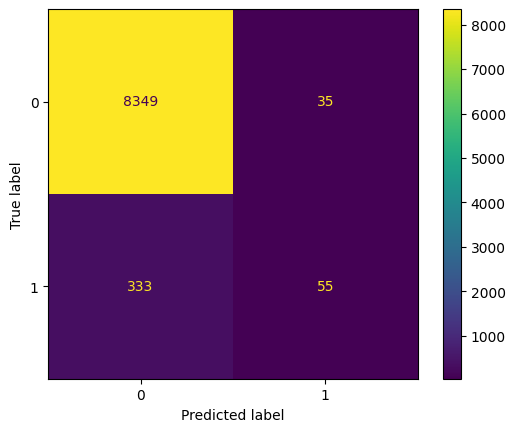

In [45]:
ConfusionMatrixDisplay.from_estimator(best_rfc, X_test, y_test)

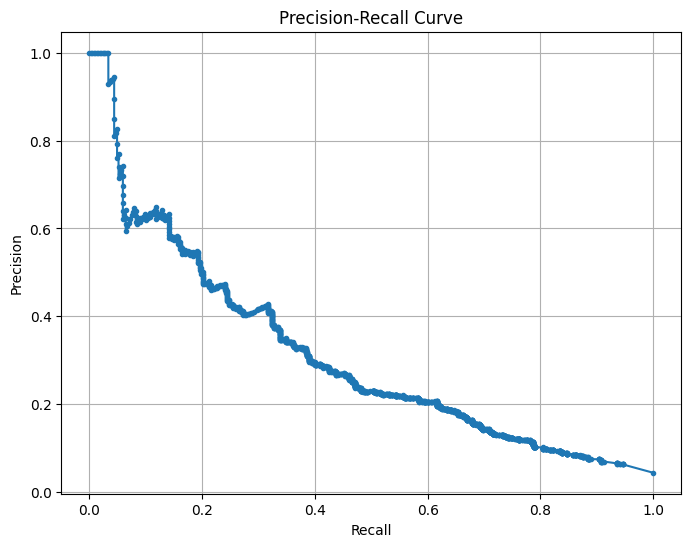

In [ ]:
y_probs_rfc = best_rfc.named_steps['rfc'].predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_rfc)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

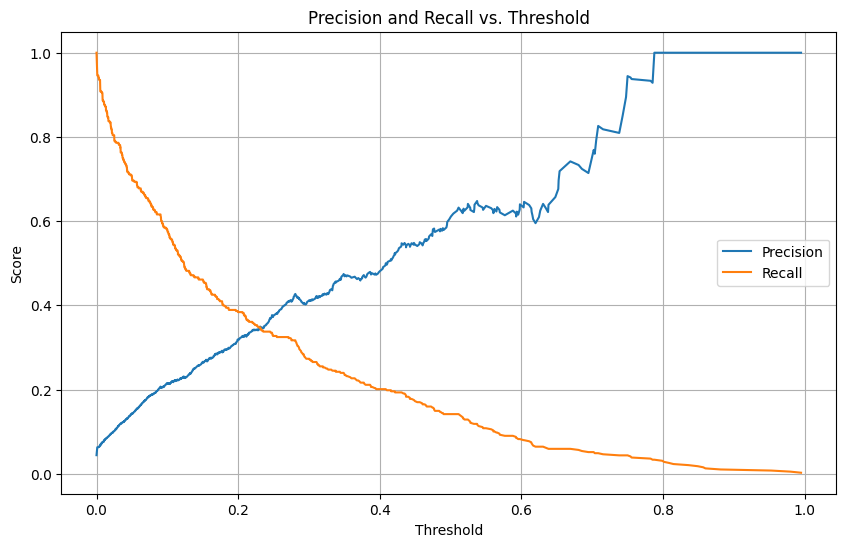

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

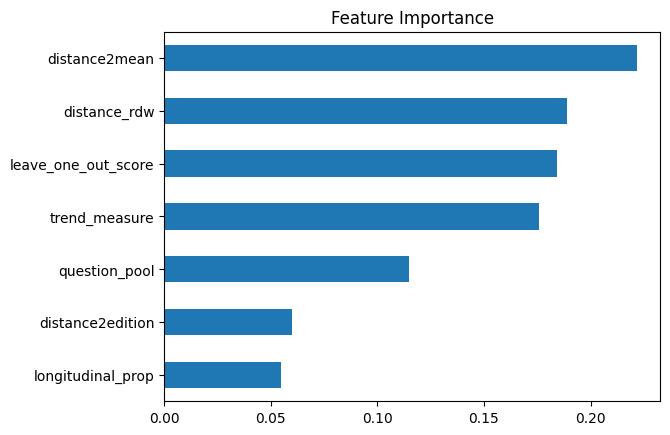

In [42]:
avg_feature_importances = (
    pd.Series(
        best_rfc.named_steps['rfc'].feature_importances_,
        index = X_train.columns
    )
    .sort_values()
    .plot(
        kind = 'barh',
        title = 'Feature Importance'
    )
)

## AdaBoost Classifier

In [ ]:
results_dtc = (
    pd.DataFrame(grid_search_dtc.cv_results_)
    .sort_values(by="mean_test_score", ascending=False)
)
results_dtc['params'].iloc[38]

{'dtc__criterion': 'entropy',
 'dtc__max_depth': 5,
 'dtc__max_features': None,
 'dtc__min_samples_leaf': 10,
 'dtc__min_samples_split': 2}

In [85]:
pipeline_ada = Pipeline([
    ('resampler', resampler),
    ('ada', AdaBoostClassifier(
        random_state = random_seed
    ))
])

param_grid_ada = {
    'ada__estimator': [
        DecisionTreeClassifier(
            criterion = 'gini',
            max_depth = 5,
            max_features = None,
            min_samples_split = 5,
            min_samples_leaf  = 2
        ),
        DecisionTreeClassifier(
            criterion = 'gini',
            max_depth = 10,
            max_features = 'sqrt',
            min_samples_split = 10,
            min_samples_leaf  = 10
        ),
        DecisionTreeClassifier(
            criterion = 'entropy',
            max_depth = 5,
            max_features = None,
            min_samples_split = 5,
            min_samples_leaf  = 5
        ),
        DecisionTreeClassifier(
            criterion = 'entropy',
            max_depth = 5,
            max_features = 'sqrt',
            min_samples_split = 5,
            min_samples_leaf  = 2
        )
    ],
    'ada__n_estimators': [50, 100, 200],
    'ada__learning_rate': [0.01, 0.01, 0.1, 0.5, 1.0]
}

grid_search_ada = GridSearchCV(
    pipeline_ada,
    param_grid_ada,
    cv      = stratified_kfold,
    scoring = f1_minority,
    n_jobs  = -1,
    verbose = True
)

In [86]:
grid_search_ada.fit(X_train, y_train)

print("Best parameters:", grid_search_ada.best_params_)
print("Best cross-validation score:", grid_search_ada.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'ada__estimator': DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=10), 'ada__learning_rate': 0.01, 'ada__n_estimators': 200}
Best cross-validation score: 0.3808265389959974


In [87]:
best_ada = grid_search_ada.best_estimator_
y_pred_ada = best_ada.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_ada))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.95      0.41      0.96      0.62      0.41      8384
          1       0.29      0.41      0.95      0.34      0.62      0.37       388

avg / total       0.94      0.93      0.43      0.94      0.62      0.41      8772



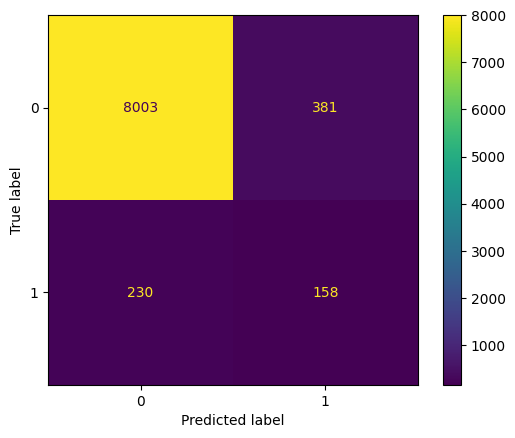

In [88]:
ConfusionMatrixDisplay.from_estimator(best_ada, X_test, y_test)

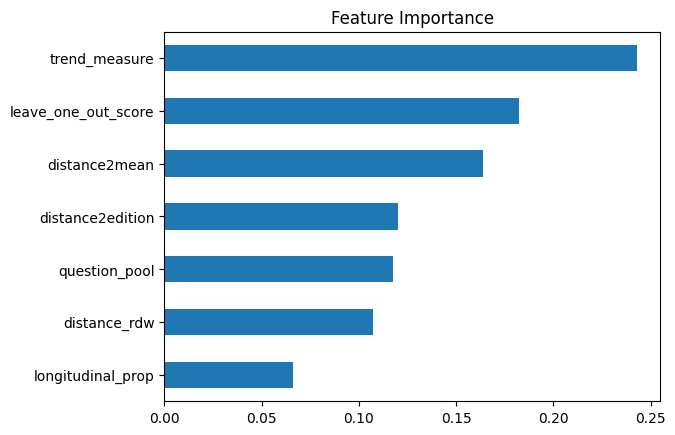

In [89]:
avg_feature_importances = (
    pd.Series(
        best_ada.named_steps['ada'].feature_importances_,
        index = X_train.columns
    )
    .sort_values()
    .plot(
        kind = 'barh',
        title = 'Feature Importance'
    )
)

## XGBoost Classifier

In [92]:
pipeline_xgb = Pipeline([
    ('resampler', resampler),
    ('xgb', XGBClassifier(
        booster      = "gbtree",
        objective    = "binary:logistic",
        eval_metric  = f1_minority,
        random_state = random_seed
    ))
])

param_grid_xgb = {
    "xgb__n_estimators": [50, 100, 200],
    "xgb__max_depth": [3, 5, 10],
    "xgb__learning_rate": [0.01, 0.1, 0.3],
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.5, 0.75, 1.0],
    "xgb__gamma": [0, 0.1, 0.5],
    "xgb__min_child_weight": [1, 3, 5]
}

grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv      = stratified_kfold,
    scoring = f1_minority,
    n_jobs  = -1,
    verbose = True
)

In [93]:
grid_search_xgb.fit(X_train, y_train)

print("Best parameters:", grid_search_xgb.best_params_)
print("Best cross-validation score:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


/Users/carlostoruno/Documents/GitHub/QRQ-ML-flagging/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'xgb__colsample_bytree': 0.75, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 50, 'xgb__subsample': 1.0}
Best cross-validation score: 0.38750589016162046


In [94]:
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_xgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.96      0.38      0.97      0.61      0.39      8384
          1       0.32      0.38      0.96      0.35      0.61      0.35       388

avg / total       0.94      0.94      0.41      0.94      0.61      0.39      8772



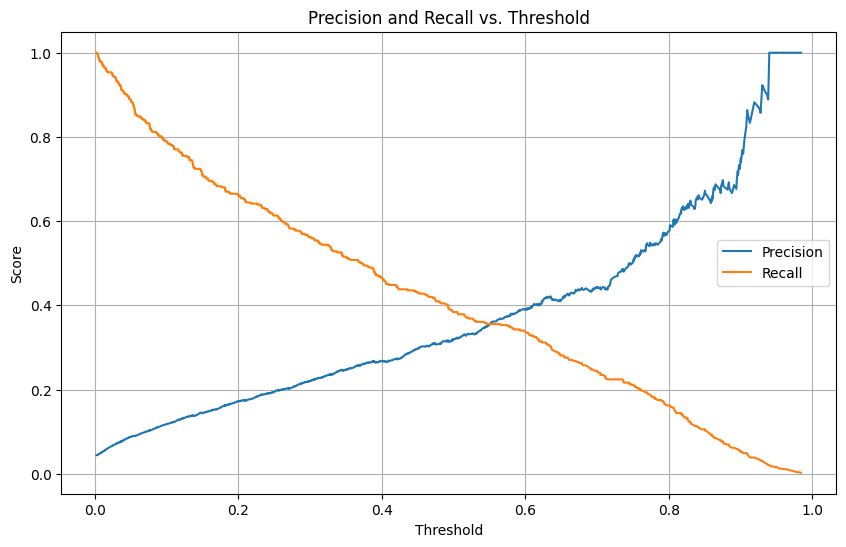

In [97]:
y_probs_xgb = best_xgb.named_steps['xgb'].predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_xgb)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
y_pred_xgb_opt = (y_probs_xgb >= 0.35).astype(int)
print(classification_report_imbalanced(y_test, y_pred_xgb_opt))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.93      0.52      0.95      0.69      0.50      8384
          1       0.25      0.52      0.93      0.33      0.69      0.46       388

avg / total       0.94      0.91      0.53      0.92      0.69      0.50      8772

